# Contents
- [Counter](#Counter)
- [Hamamatsu](#Hamamatsu)
- [Count_Plots](#Count_Plots)
- [Cuts](#Cuts)
- [Loading](#Loading)
- [Retention](#Retention)
- [Copy](#Copy)
- [Settings](#Settings)
- [TODO](#TODO)
- [Appendix](#Appendix)

In [1]:
%matplotlib notebook

import h5py
import matplotlib.pyplot as plt
from numpy import *
import pandas as pd
import os
import sys
from scipy.optimize import curve_fit
from typing import Dict, Any
import recordclass.recordclass as rc
from itertools import product
if (os.name == 'posix'):
    repo_path = r"/Volumes/C/Public/Users/Hybrid/Repos/Hybrid_H5/H5_python3"
else:
    repo_path = r"C:\Users\Hybrid\Repos\Hybrid_H5\H5_python3"
sys.path.append(repo_path)
# local imports
import HamamatsuH5
import counterh5
from Iterations import Iterations,seed_permute
from PlottingH5 import default_plotting, iterate_plot_2D
from FittingH5 import *

In [2]:
def plt_subplots(nrows=1, ncols=1,*args,**kwargs):
    """
    Function to wrap plt.subplots and make sure the same block of code can plot many axes and a single axis
    """
    fig,axarr = plt.subplots(nrows,ncols,*args,**kwargs)
    if nrows == 1 and ncols == 1:
        axarr = [axarr]
    return fig,axarr
    
h5file = h5py.File('results.hdf5',mode='r+')

iterations = Iterations(h5file)
#Find number of measurements per experiment
measurements = h5file['settings/experiment/measurementsPerIteration'][()]+1
num_its = len(h5file['iterations'])

iterations
#Find independent variable names and values
#indep_vars = DataH5.get_indep_vars(h5file)
#iVars = list(indep_vars.keys())

# map iterations to independent variable values
# iterations = DataH5.make_iterations_df(h5file, iVars)

  iteration
0         0

# Counter

In [3]:
drop_bins = h5file["/iterations/0/variables/RO1_drops"][()]
ro_bins = h5file["/iterations/0/variables/RO1_bins"][()]
shots_per_measurement = int(h5file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])
counter_bin, counter_shot = counterh5.load_data(h5file, drop_bins, ro_bins)
count_data = counter_shot

## Plot data bins as bar graphs

<IPython.core.display.Javascript object>


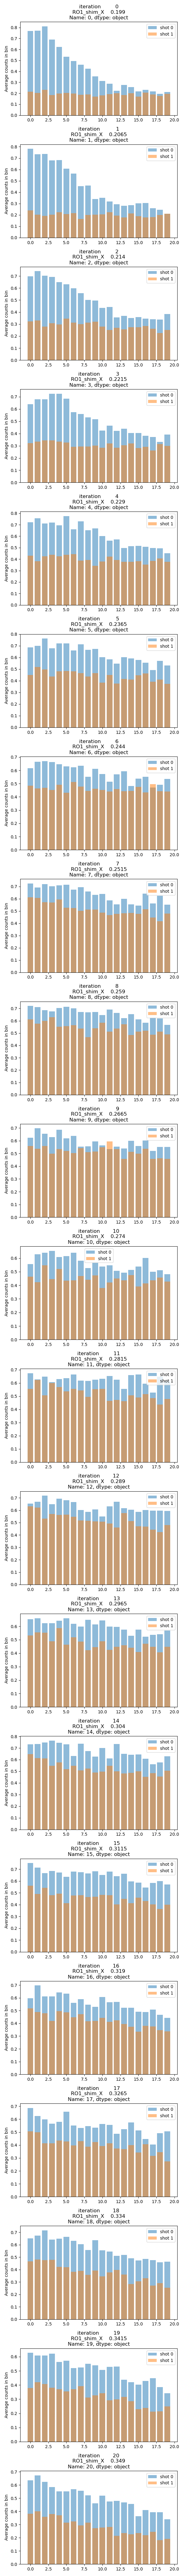

In [4]:
plots = True
if plots and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} bin bar graphs. Are you sure you want to do that? (y/N) : ").upper()[0]
    plots = ans=="Y"
if plots:
    fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(iteration)
        # bin shot 0 and shot 1 the same way
        for shot in range(shots_per_measurement):
            axarr[iteration].bar(range(ro_bins),counter_bin.mean(1)[iteration,shot,drop_bins:],alpha=0.5,label = f"shot {shot}")
        axarr[iteration].set_ylabel("Average counts in bin")
        axarr[iteration].legend()
        axarr[iteration].set_title(str(row))
    fig.tight_layout()
    fig.show()

To analyze count data go to:
- [Count_Plots](#Count_Plots)

# Hamamatsu

In [ ]:
# Set ROI
fg = HamamatsuH5.set_frame_grabber_region(h5file)
width = fg['right']-fg['left']
height = fg['bottom']-fg['top']

# For documentation try > help(HMROI)
roi = HamamatsuH5.HMROI(width,height,dic = {
    "left" : 1,
    "right" : 4,
    "top" : 4,
    "bottom" : 7
})
#roi = HamamatsuH5.HMROI(width,height)

#Load data into memory
shots_per_measurement = int(h5file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])
# pixel-by-pixel data indexed : [iteration, measurement, shot, y-pixel, x-pixel]
hm_pix = HamamatsuH5.load_data(h5file,roi)

#take pixel-by-pixel data and treat it into counter data then mean data
# "count" data indexed : [iteration, measurement, shot]
hm_counts = hm_pix.sum(3).sum(3)
# mean count data indexed : [iteration, shot]
mus = hm_counts.mean(1)
# standard deviation in mean indexed : [iteration, shot]
ers = hm_counts.std(1)/sqrt(measurements)

count_data = hm_counts

## Show images taken within ROI

In [ ]:
## show average image for one shot for each iteration
im_shot = 0 # shot to image

fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
for index, row in iterations.iterrows():
    iteration = row['iteration']
    axarr[iteration].imshow(hm_pix[iteration,:,im_shot,:,:].mean(0))
    axarr[iteration].set_title(str(row))
fig.tight_layout()
fig.show()

## Plot Histogram data of each pixel for each iteration
* Very memory hungry!
* Please clear output before saving, copying or pushing if this cell was run

In [ ]:
im_width = roi.right-roi.left
im_height = roi.bottom-roi.top
for iteration, row in iterations.iterrows():
    i = row['iteration']
    fig,axarr = plt.subplots(im_height,im_width,figsize = (10,10))
    for y in range(im_height):
        for x in range(im_width):
            bns = 20
            for shot in range(shots_per_measurement):
                axarr[y,x].hist(hm_pix[i,:,shot,y,x],bins=bns,histtype='step',label = f"Shot {shot}")
            axarr[y,x].set_title(f"x = {x}, y = {y}")
            axarr[y,x].legend()
    fig.suptitle(str(row))
    fig.tight_layout()
    fig.show()

# Count_Plots
Plot count data from some instrument (could be Hamamatsu, counter or other single-photon sensitive instrument)

## Plot Histograms of count data

<IPython.core.display.Javascript object>


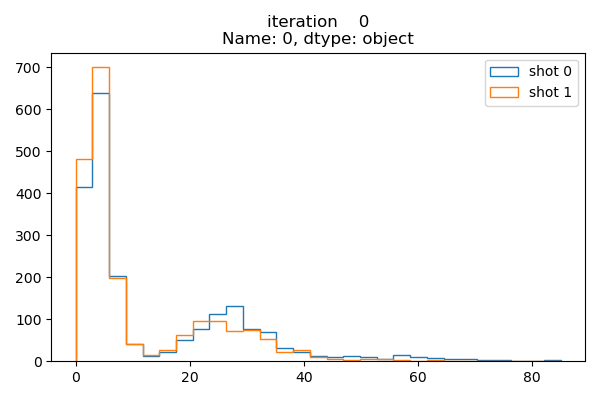

In [4]:
plots = True
if plots and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} histograms. Are you sure you want to do that? (y/N) : ").upper()[0]
    plots = ans=="Y"
if plots:
    n_bins = 30
    fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(iteration)
        # bin shot 0 and shot 1 the same way
        bns = linspace(count_data[iteration,:,:].min(), count_data[iteration,:,:].max(), n_bins)
        # bin shot 0 and shot 1 differently
        # bns = n_bins
        for shot in range(shots_per_measurement):
            axarr[iteration].hist(count_data[iteration,:,shot],histtype='step', label = f"shot {shot}",bins=bns)
        axarr[iteration].legend()
        axarr[iteration].set_title(str(row))
        fig.tight_layout()
    fig.show()
else:
    print("You have chosen not to plot the histograms.")

## Plot mean count data
* If only 1 iteration : Prints out means for each shot and the corresponding standard deviation
* If there is 1 independent variable : Plot means for each iteration with error bars
* If there are 2 independent variables : show image of means for each iteration.

<IPython.core.display.Javascript object>


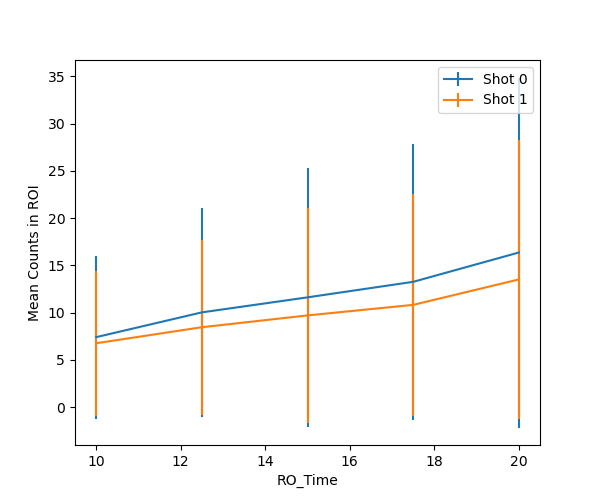

In [5]:
default_plotting(iterations,count_data.mean(1),count_data.std(1),shots_per_measurement,description="Mean Counts in ROI")

## 2D as many 1D

* Often, when a 2D scan is performed it's more enlightening to plot each row (or column) of data as a line graph

In [ ]:
iterate_plot_2D(**{
    "iterations": iterations,
    "data": count_data.mean(1),
    "data_error": count_data.std(1),
    "description": "Counts in ROI",
})

# Cuts

In [5]:
# Utility and calibration functions to be moved to files

def fit_and_plot_hist(func,counter_data,bns,guess,title="",plots=True):
    
    hist, bin_edges = histogram(counter_data,bins=bns)
    mids = (bin_edges[0:-1] + bin_edges[1:])/2
    try:
        popt,pcov = curve_fit(f=func,xdata=mids,ydata=hist,p0 = guess)
    except RuntimeError as e:
        print(f"Unable to fit\n{e}")
        popt = array(guess)
        pcov = zeros((len(popt),len(popt)))
        bad_fit = True
    else:
        bad_fit = False
    perr = sqrt(diag(pcov))
    
    if plots:
        fig,ax = plt.subplots(1,1,figsize=(8,6))
        xlin = linspace(min(counter_data),max(counter_data),1000)
        ax.hist(counter_data,bins=bns,histtype='step',label="Raw Data")
        label = "Guess" if bad_fit else "Fit"
        ax.plot(xlin,func(xlin,*popt),label=label)
        ax.set_title(title.format(popt,perr))
        ax.legend()
        fig.tight_layout()
        fig.show()
    else:
        fig, ax = (None, None)
    return popt, pcov, perr, fig, ax

def hamamatsu_count_calibration(counter_data,offset,EM_gain, analog_gain):
    """
    converts hamamatsu counting data to number of incident photons
    Args:
        counter_data : ndarray of camera counts
        offset : couning offset
        EM_gain : EM gain setting on the camera
        analog_gain : analog gain setting on the camera
    """
    return (counter_data - offset) / (EM_gain * analog_gain)

def hamamatsu_inv_calibration(counter_data, offset, EM_gain, analog_gain):
    """
    converts photon counting data to haamamtsu camera count data. 
    
    Inverse function of hamamatsu_count_calibration
    Args:
        counter_data : ndarray of camera counts
        offset : couning offset
        EM_gain : EM gain setting on the camera
        analog_gain : analog gain setting on the camera
    """
    return (counter_data * EM_gain * analog_gain) + offset

def expand_iter_array(iterations,iter_array,no_measurements,no_shots):
    """
    Expands an array of len() == len(iterations) to an ndarray of the shape of shot-by-shot data.
    
    An iter array is an array of shape = (len(iteration),), and is indexed [iteration].
        The assumption being that it's an array containing iteration-by-iteration data.
    An array with shot-by-shot data is indexed [iteration,measurement,shot]
    """
    if len(iter_array) != len(iterations):
        raise ValueError("Iter arrays must have length of iterations")
    fixed_array = ones((len(iterations),no_measurements,no_shots))
    for i, row in iterations.iterrows():
        iteration = row['iteration']
        fixed_array[iteration] = iter_array[iteration]*fixed_array[iteration]
    return fixed_array

C:\Users\Hybrid\Repos\Hybrid_H5\H5_python3\FittingH5.py:81: RuntimeWarning: invalid value encountered in power
  return a*exp(-mu)*mu**x/gamma(x+1)


<IPython.core.display.Javascript object>


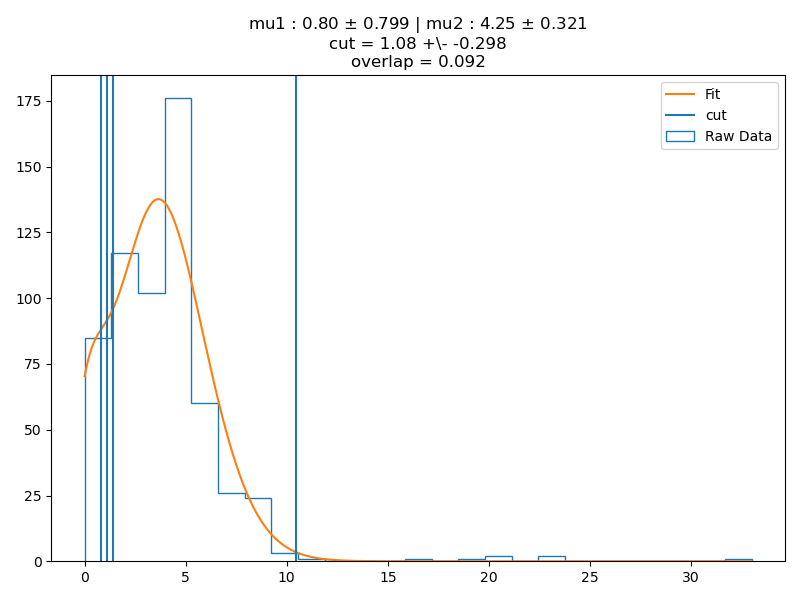

Overlap : 0.09170312309548583
Cut : 1.0823876723410621 +\- -0.2983116710115515
popt : [  0.79824422   4.25362014 134.41591102 696.00711968]
perr : [ 0.79895334  0.32094983 48.05853705 64.68949278]
pcov : [[ 1.03008790e-01  1.86790754e-01 -9.70329442e+00  1.06819404e+01]
 [ 1.86790754e-01  6.38326433e-01 -3.46129704e+01  2.24424401e+01]
 [-9.70329442e+00 -3.46129704e+01  4.18473048e+03 -1.64085607e+03]
 [ 1.06819404e+01  2.24424401e+01 -1.64085607e+03  2.30962298e+03]]


<IPython.core.display.Javascript object>


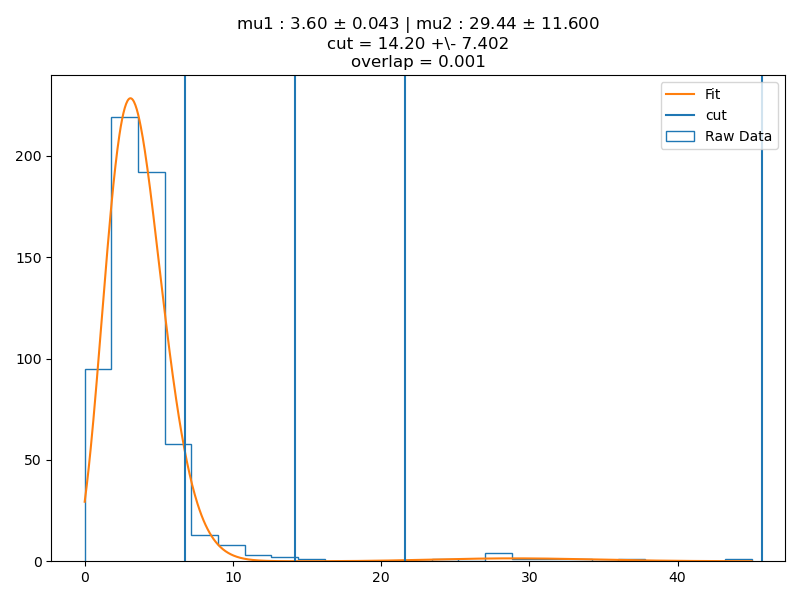

Overlap : 0.0009802750716764147
Cut : 14.201612614039961 +\- 7.402288680472882
popt : [   3.59884809   29.43990885 1073.36717305   19.522284  ]
perr : [ 0.04316694 11.59988376 17.61561973 29.55890313]
pcov : [[ 1.86338429e-03  4.64527624e-05  1.43717120e-01 -1.66860796e-05]
 [ 4.64527624e-05  1.34557303e+02  7.48010956e-03  2.24866592e+01]
 [ 1.43717120e-01  7.48010956e-03  3.10310058e+02 -2.56766035e-03]
 [-1.66860796e-05  2.24866592e+01 -2.56766035e-03  8.73728754e+02]]


<IPython.core.display.Javascript object>


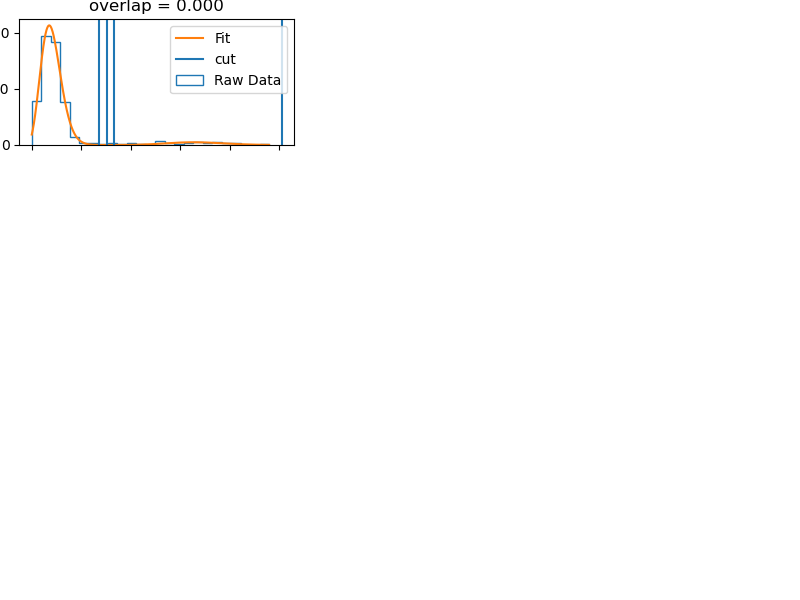

Overlap : 0.0002553168166587871
Cut : 15.158221156178966 +\- 1.5132469698985054
popt : [   4.04481977   33.27648175 1063.2204855    70.53251306]
perr : [ 0.03231266  2.38559287 12.2620344  20.62672142]
pcov : [[ 1.04410768e-03  1.55204502e-06  7.05029460e-02 -1.75311178e-06]
 [ 1.55204502e-06  5.69105333e+00  2.17790109e-04  3.07682089e+00]
 [ 7.05029460e-02  2.17790109e-04  1.50357488e+02 -2.36722144e-04]
 [-1.75311178e-06  3.07682089e+00 -2.36722144e-04  4.25461637e+02]]


<IPython.core.display.Javascript object>


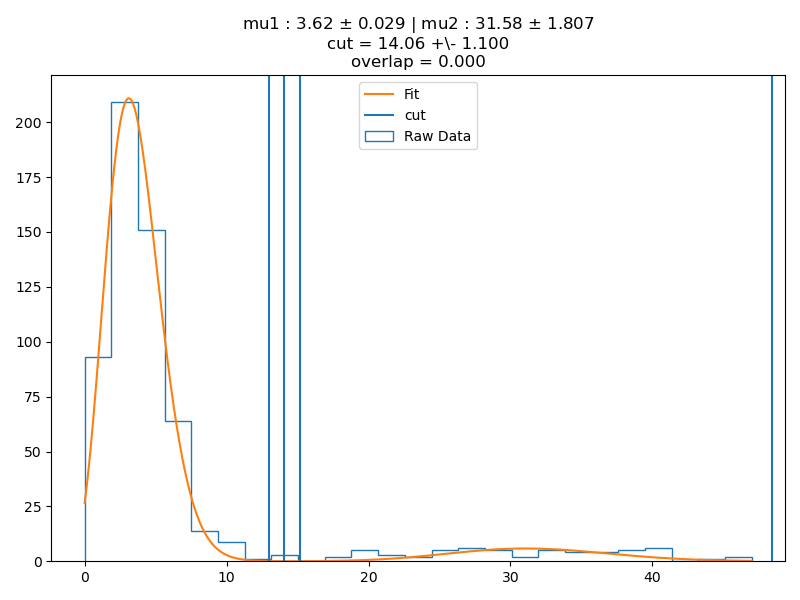

Overlap : 0.0002760288368230591
Cut : 14.061813209633506 +\- 1.0999889474244
popt : [  3.62114678  31.5776732  994.44683097  81.90932409]
perr : [ 0.02903385  1.80692633 10.93572142 18.64543261]
pcov : [[ 8.42964171e-04  1.39737609e-06  5.95694162e-02 -1.91515224e-06]
 [ 1.39737609e-06  3.26498276e+00  2.00994125e-04  2.14042332e+00]
 [ 5.95694162e-02  2.00994125e-04  1.19590003e+02 -2.65935477e-04]
 [-1.91515224e-06  2.14042332e+00 -2.65935477e-04  3.47652157e+02]]


<IPython.core.display.Javascript object>


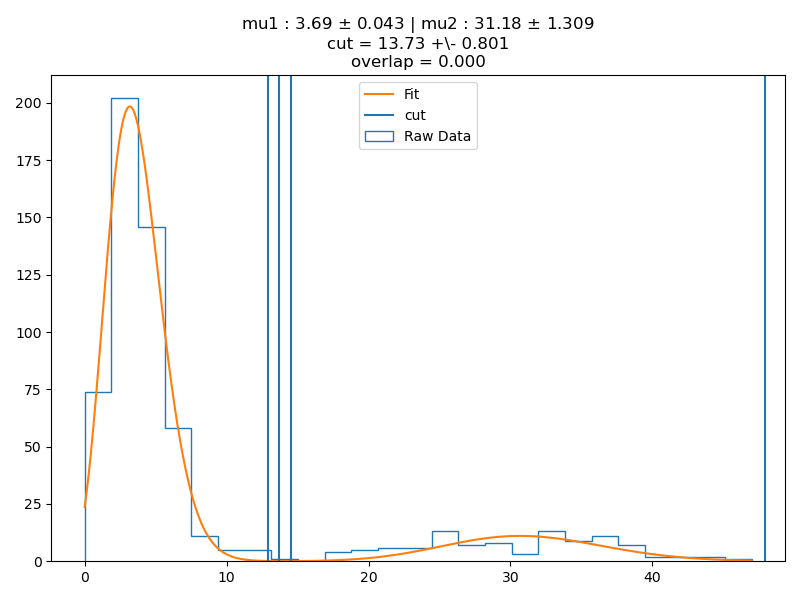

Overlap : 0.00027353373302893704
Cut : 13.725981805851873 +\- 0.8007008049820846
popt : [  3.68785114  31.1810627  944.51043173 154.79555295]
perr : [ 0.04287674  1.3090095  15.18547951 25.69635108]
pcov : [[ 1.83841503e-03  2.14308897e-06  1.21103817e-01 -5.76100216e-06]
 [ 2.14308897e-06  1.71350588e+00  2.90893816e-04  2.14504287e+00]
 [ 1.21103817e-01  2.90893816e-04  2.30598788e+02 -7.67981727e-04]
 [-5.76100216e-06  2.14504287e+00 -7.67981727e-04  6.60302459e+02]]


<IPython.core.display.Javascript object>


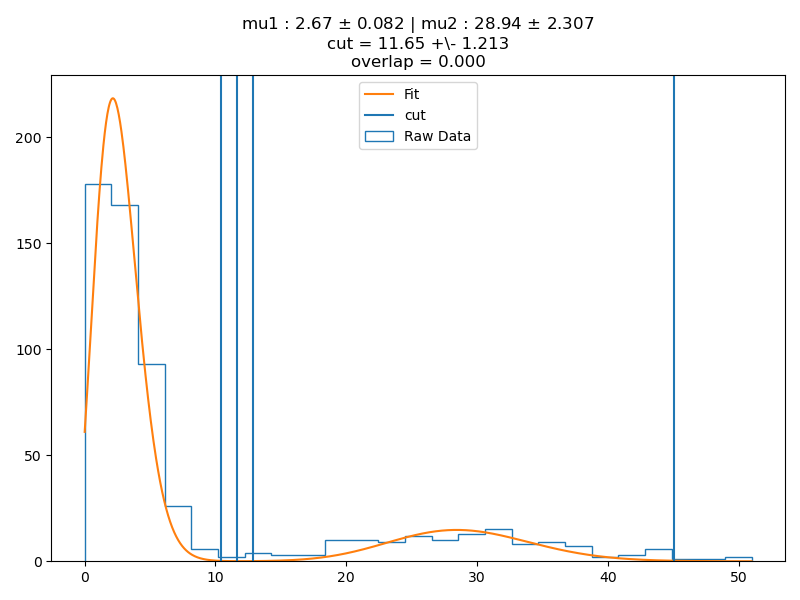

Overlap : 0.00016676620830879322
Cut : 11.646856285346624 +\- 1.2134873616532844
popt : [  2.66909536  28.94433797 880.43338329 199.09906261]
perr : [ 0.08194908  2.30658446 33.81281133 60.49116873]
pcov : [[ 6.71565140e-03  3.90758086e-06  6.62238753e-01 -1.32288711e-05]
 [ 3.90758086e-06  5.32033189e+00  7.04791915e-04  9.18937065e+00]
 [ 6.62238753e-01  7.04791915e-04  1.14330621e+03 -2.31796831e-03]
 [-1.32288711e-05  9.18937065e+00 -2.31796831e-03  3.65918149e+03]]


<IPython.core.display.Javascript object>


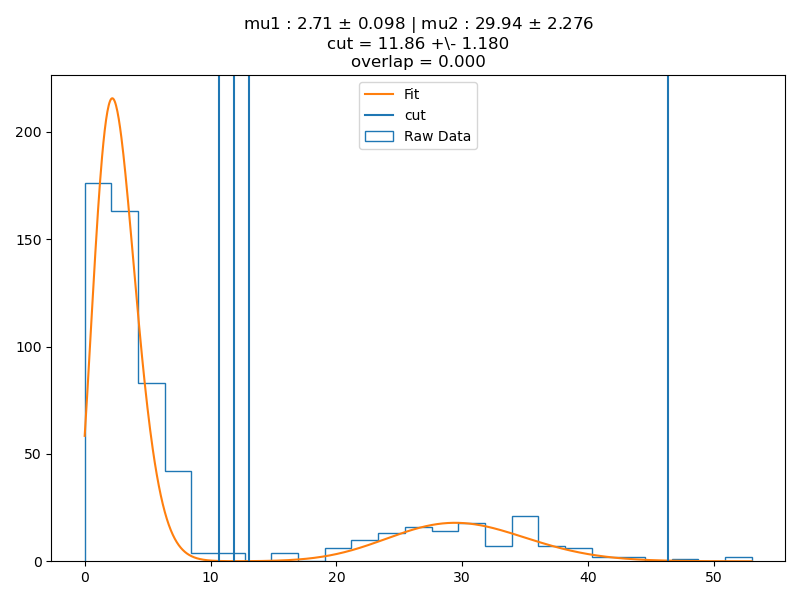

Overlap : 0.00011168345526232257
Cut : 11.860840342153432 +\- 1.1800495962304631
popt : [  2.70796258  29.93540562 876.20989073 245.49665534]
perr : [ 0.09783608  2.27569873 40.28622121 72.35571113]
pcov : [[ 9.57189815e-03  2.61350703e-06  9.45914541e-01 -1.04608242e-05]
 [ 2.61350703e-06  5.17880471e+00  4.69291256e-04  1.06628020e+01]
 [ 9.45914541e-01  4.69291256e-04  1.62297962e+03 -1.82431560e-03]
 [-1.04608242e-05  1.06628020e+01 -1.82431560e-03  5.23534893e+03]]


<IPython.core.display.Javascript object>


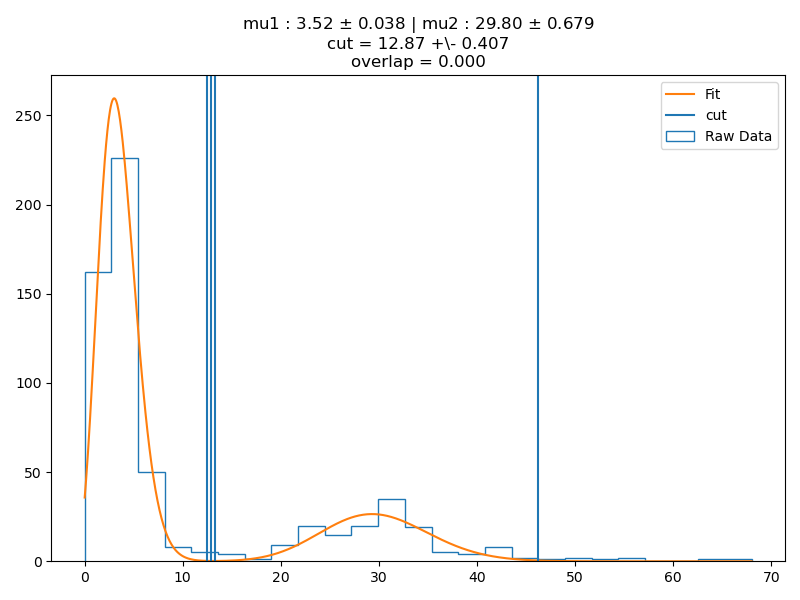

Overlap : 0.00031176225613700325
Cut : 12.865291143935037 +\- 0.40668526542590816
popt : [   3.51875311   29.79914476 1206.57385502  361.72025695]
perr : [ 0.03756471  0.67866075 18.99874956 31.86641156]
pcov : [[ 1.41110760e-03  1.53690996e-06  1.18326817e-01 -1.00863890e-05]
 [ 1.53690996e-06  4.60580412e-01  3.01799300e-04  1.40366531e+00]
 [ 1.18326817e-01  3.01799300e-04  3.60952485e+02 -1.90199047e-03]
 [-1.00863890e-05  1.40366531e+00 -1.90199047e-03  1.01546819e+03]]


<IPython.core.display.Javascript object>


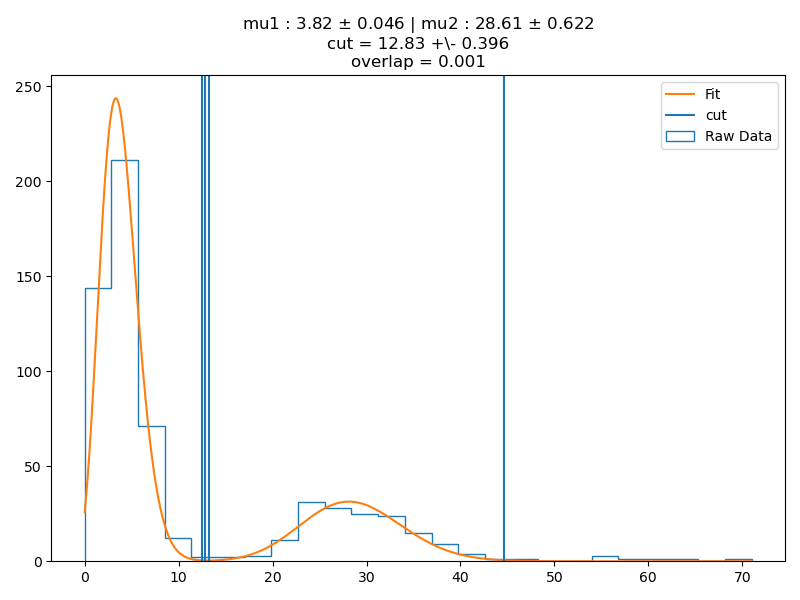

Overlap : 0.0006265901922734088
Cut : 12.830455808394511 +\- 0.3960895053595226
popt : [   3.8239143    28.61287308 1181.80051193  420.48423127]
perr : [ 0.04623536  0.62181863 21.23541851 34.64022226]
pcov : [[ 2.13770893e-03  5.93800872e-06  1.30836405e-01 -5.00138041e-05]
 [ 5.93800872e-06  3.86658412e-01  9.96034319e-04  1.42685941e+00]
 [ 1.30836405e-01  9.96034319e-04  4.50942999e+02 -8.05956063e-03]
 [-5.00138041e-05  1.42685941e+00 -8.05956063e-03  1.19994500e+03]]


<IPython.core.display.Javascript object>


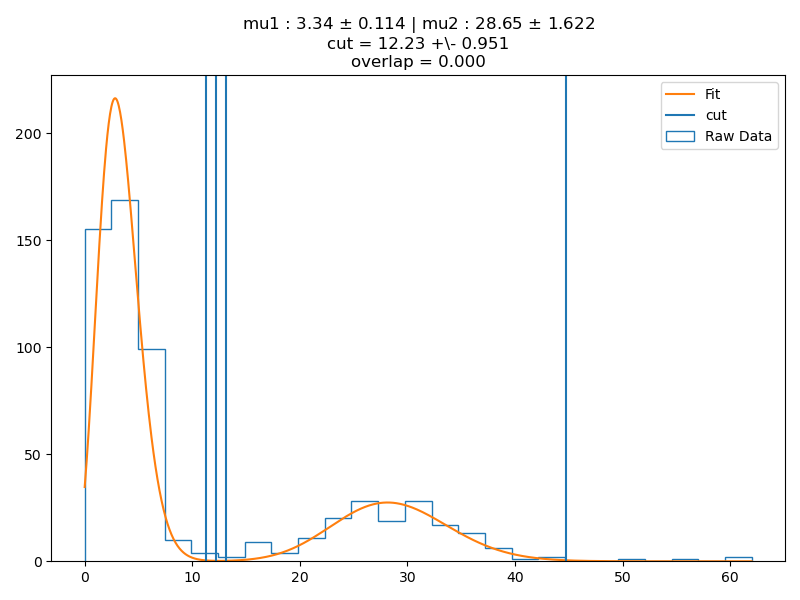

Overlap : 0.0003639230707689051
Cut : 12.231591019618072 +\- 0.9505146629540062
popt : [  3.33932574  28.65242327 978.59837663 367.89287959]
perr : [ 0.11385324  1.6221846  46.79112109 79.0111124 ]
pcov : [[ 1.29625604e-02  1.65884320e-05  9.72916581e-01 -1.14944784e-04]
 [ 1.65884320e-05  2.63148288e+00  2.73922026e-03  8.48447872e+00]
 [ 9.72916581e-01  2.73922026e-03  2.18940901e+03 -1.83538002e-02]
 [-1.14944784e-04  8.48447872e+00 -1.83538002e-02  6.24275588e+03]]


<IPython.core.display.Javascript object>


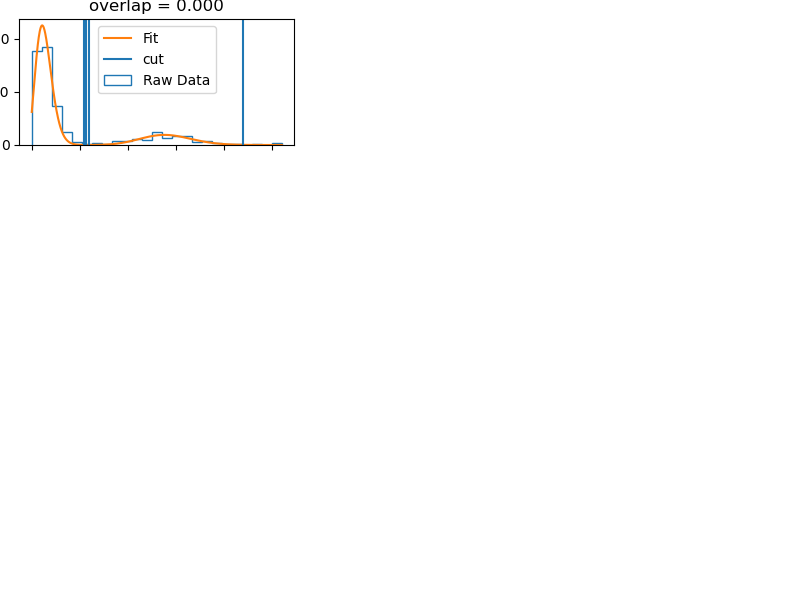

Overlap : 0.00022294628823009308
Cut : 11.364794518904471 +\- 0.551885716808556
popt : [  2.68313746  28.08977357 908.68007956 251.97562504]
perr : [ 0.04617582  1.0372263  19.71602098 34.94818459]
pcov : [[ 2.13220635e-03  1.75745406e-06  2.18583883e-01 -7.87080740e-06]
 [ 1.75745406e-06  1.07583839e+00  3.33282920e-04  2.42360044e+00]
 [ 2.18583883e-01  3.33282920e-04  3.88721483e+02 -1.44610778e-03]
 [-7.87080740e-06  2.42360044e+00 -1.44610778e-03  1.22137561e+03]]


<IPython.core.display.Javascript object>


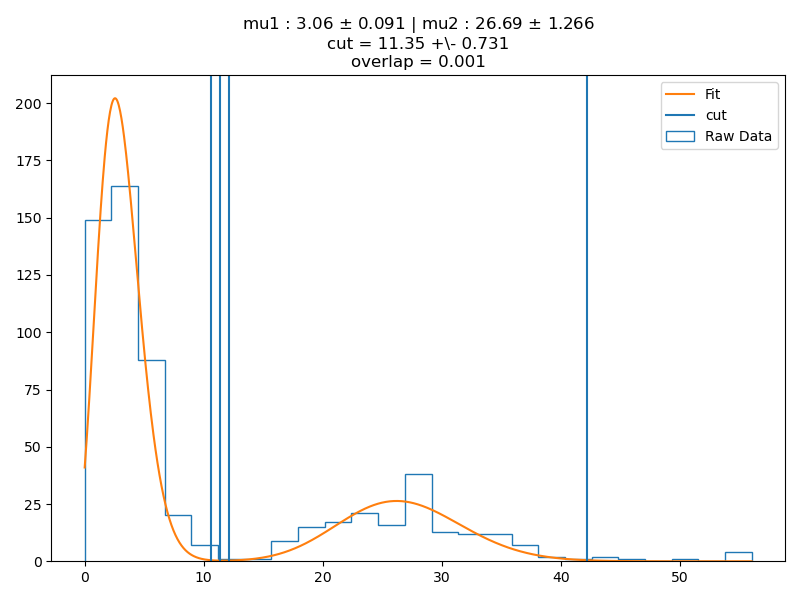

Overlap : 0.0005456731798101465
Cut : 11.347050410568565 +\- 0.7311302065820912
popt : [  3.06138683  26.68807062 874.73737215 340.45645236]
perr : [ 0.09145375  1.26601903 34.8579233  59.1373204 ]
pcov : [[ 8.36378750e-03  2.09630280e-05  6.57846360e-01 -1.44007421e-04]
 [ 2.09630280e-05  1.60280419e+00  3.42586695e-03  5.13607132e+00]
 [ 6.57846360e-01  3.42586695e-03  1.21507482e+03 -2.27680816e-02]
 [-1.44007421e-04  5.13607132e+00 -2.27680816e-02  3.49722266e+03]]


<IPython.core.display.Javascript object>


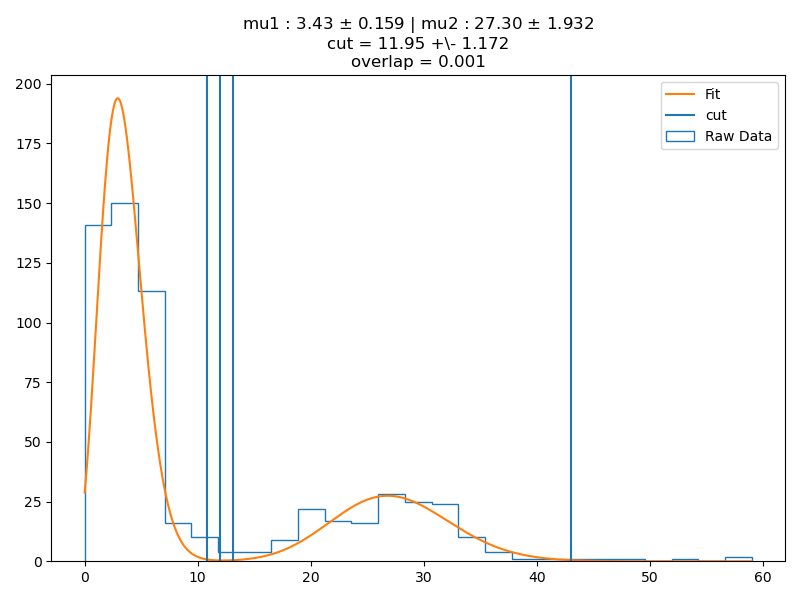

Overlap : 0.0006464885632106504
Cut : 11.94785419451733 +\- 1.1716574602766723
popt : [  3.43195113  27.30118683 889.68503071 358.75096347]
perr : [ 0.15872522  1.93194893 56.54943504 94.01422023]
pcov : [[ 2.51936945e-02  7.41956544e-05  1.59908730e+00 -5.44972768e-04]
 [ 7.41956544e-05  3.73242666e+00  1.06069475e-02  1.23186794e+01]
 [ 1.59908730e+00  1.06069475e-02  3.19783860e+03 -7.50537083e-02]
 [-5.44972768e-04  1.23186794e+01 -7.50537083e-02  8.83867361e+03]]


<IPython.core.display.Javascript object>


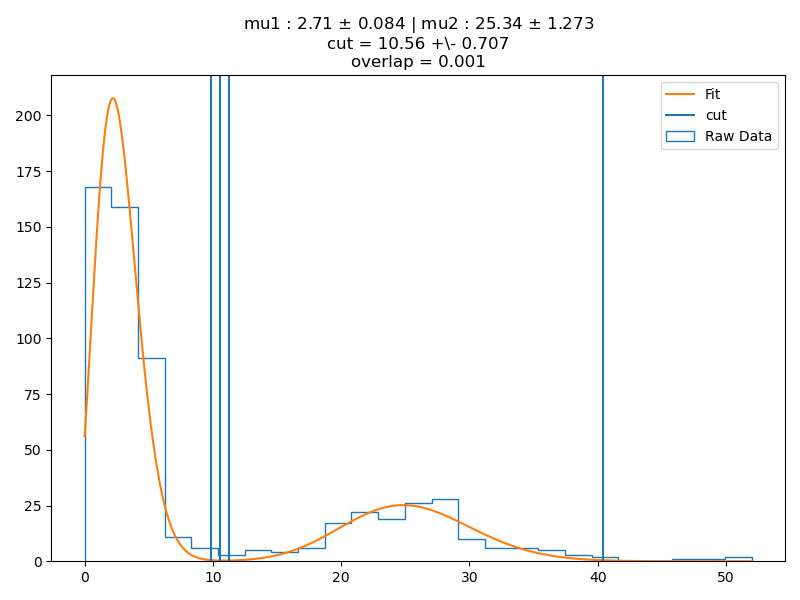

Overlap : 0.0006084523413090589
Cut : 10.561422144038115 +\- 0.7073984131901421
popt : [  2.7109382   25.33659399 844.19806115 317.26580484]
perr : [ 0.08377353  1.27289964 32.99487364 56.8746449 ]
pcov : [[ 7.01800496e-03  2.31334561e-05  6.54541694e-01 -1.52198959e-04]
 [ 2.31334561e-05  1.62027349e+00  4.17984944e-03  5.09781733e+00]
 [ 6.54541694e-01  4.17984944e-03  1.08866169e+03 -2.66599558e-02]
 [-1.52198959e-04  5.09781733e+00 -2.66599558e-02  3.23472523e+03]]


<IPython.core.display.Javascript object>


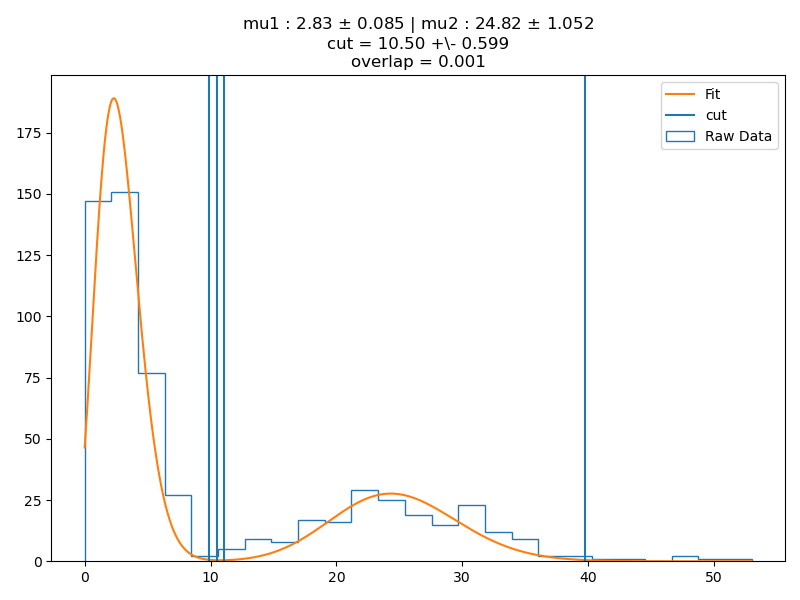

Overlap : 0.000808737171586983
Cut : 10.50369951610651 +\- 0.5990967791489751
popt : [  2.82692486  24.82398448 785.33228769 344.67793424]
perr : [ 0.08495845  1.05234379 30.38954866 51.60985759]
pcov : [[ 7.21793822e-03  3.26971951e-05  5.83651103e-01 -2.44818676e-04]
 [ 3.26971951e-05  1.10742746e+00  5.32374875e-03  3.86385521e+00]
 [ 5.83651103e-01  5.32374875e-03  9.23524668e+02 -3.84880088e-02]
 [-2.44818676e-04  3.86385521e+00 -3.84880088e-02  2.66357740e+03]]


<IPython.core.display.Javascript object>


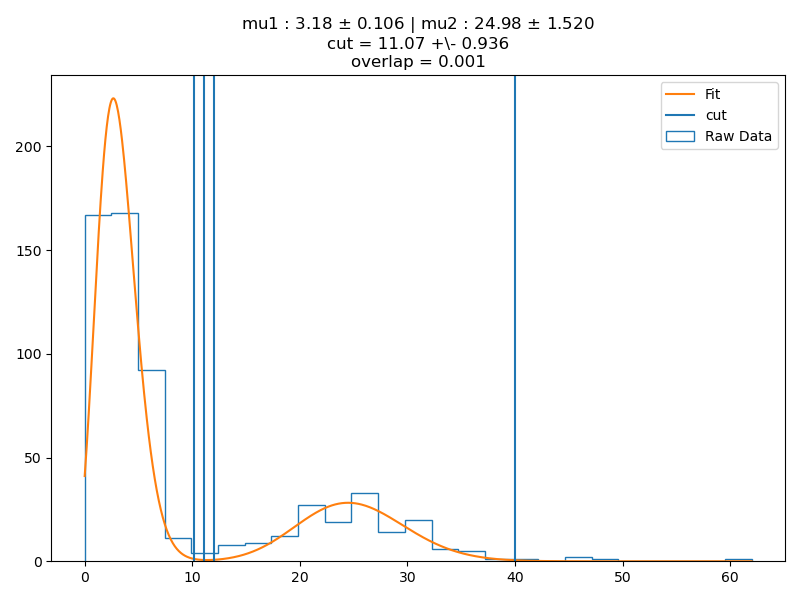

Overlap : 0.001189284906172538
Cut : 11.069534621926305 +\- 0.9361423202741632
popt : [  3.17597392  24.98100069 984.24705412 352.82596231]
perr : [ 0.10614372  1.52008999 46.16362356 76.07045758]
pcov : [[ 1.12664898e-02  9.46238187e-05  9.88150353e-01 -7.55074796e-04]
 [ 9.46238187e-05  2.31067357e+00  1.84039168e-02  8.20051872e+00]
 [ 9.88150353e-01  1.84039168e-02  2.13108014e+03 -1.41230257e-01]
 [-7.55074796e-04  8.20051872e+00 -1.41230257e-01  5.78671452e+03]]


<IPython.core.display.Javascript object>

Overlap : 0.00034836490646279164
Cut : 9.697566032234224 +\- 0.6972864869863559
popt : [  2.12072706  24.87952176 846.89409624 276.4938775 ]
perr : [ 0.0691152   1.40672937 30.48584896 55.28035764]
pcov : [[ 4.77691068e-03  8.74235059e-06  6.84441851e-01 -4.69517635e-05]
 [ 8.74235059e-06  1.97888753e+00  2.00816612e-03  5.52619621e+00]
 [ 6.84441851e-01  2.00816612e-03  9.29386987e+02 -1.05303596e-02]
 [-4.69517635e-05  5.52619621e+00 -1.05303596e-02  3.05591794e+03]]


<IPython.core.display.Javascript object>

Overlap : 0.0013564259053401068
Cut : 11.063771878830797 +\- 1.0347371584537874
popt : [  3.11529272  24.69545316 977.45199109 259.77780757]
perr : [ 0.08769458  1.6667829  37.30738778 61.76986936]
pcov : [[ 7.69033901e-03  9.35338529e-05  6.63431204e-01 -5.54536456e-04]
 [ 9.35338529e-05  2.77816524e+00  1.76468103e-02  7.34380371e+00]
 [ 6.63431204e-01  1.76468103e-02  1.39184118e+03 -1.00637797e-01]
 [-5.54536456e-04  7.34380371e+00 -1.00637797e-01  3.81551676e+03]]


<IPython.core.display.Javascript object>

Overlap : 0.005842422308978455
Cut : 11.05146282168017 +\- 0.4864499701666378
popt : [  3.63677802  22.11038252 924.30156065 211.73050993]
perr : [ 0.03863175  0.65810413 13.48211629 21.01400786]
pcov : [[ 1.49241214e-03  1.49907481e-04  9.64892986e-02 -9.28946333e-04]
 [ 1.49907481e-04  4.33101042e-01  2.35945872e-02  1.04270488e+00]
 [ 9.64892986e-02  2.35945872e-02  1.81767460e+02 -1.38554243e-01]
 [-9.28946333e-04  1.04270488e+00 -1.38554243e-01  4.41588527e+02]]


<ipython-input-5-0f717645da80>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1,1,figsize=(8,6))


<IPython.core.display.Javascript object>

Overlap : 0.0059688348056483485
Cut : 10.829035302018937 +\- 0.6092294145247614
popt : [  3.40467066  21.71837655 901.85216905 156.30981126]
perr : [ 0.03598948  0.84340073 12.72641591 20.06136401]
pcov : [[ 1.29524250e-03  1.62014545e-04  8.90626569e-02 -7.36756492e-04]
 [ 1.62014545e-04  7.11324797e-01  2.62439708e-02  1.28727293e+00]
 [ 8.90626569e-02  2.62439708e-02  1.61961662e+02 -1.13282465e-01]
 [-7.36756492e-04  1.28727293e+00 -1.13282465e-01  4.02458326e+02]]


<IPython.core.display.Javascript object>

Overlap : 0.035416488738657256
Cut : 10.031614779260401 +\- 4.9499308052035005
popt : [  3.69065302  17.23993644 721.61989104 106.46310377]
perr : [ 0.24740839  5.37504223 66.89462258 97.62032368]
pcov : [[ 6.12109121e-02  8.18340984e-02  3.13182794e+00 -3.95268633e-01]
 [ 8.18340984e-02  2.88910790e+01  1.18234955e+01  4.41566864e+01]
 [ 3.13182794e+00  1.18234955e+01  4.47489053e+03 -5.22184124e+01]
 [-3.95268633e-01  4.41566864e+01 -5.22184124e+01  9.52972759e+03]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
offset = 20940
EM_gain = 500
analog_gain = 1
#count_data = hamamatsu_count_calibration(hm_counts, offset, EM_gain, analog_gain)
shot_to_fit = 1

plots = True

fit_to = "Poisson"
if fit_to == "Poisson":
    func = double_poisson
    get_cut = poisson_intercept
    get_cut_err = cut_err_poisson
    get_overlap = poisson_discrimination_error
    guess = {
        "mu1": 5,
        "mu2": 30,
        "a1": 1000,
        "a2": 4000
    }
elif fit_to == "Gauss":
    func = double_gaussian
    get_cut = gauss_cut
    get_cut_err = cut_err_gauss
    get_overlap = gauss_discrimination_error
    guess = {
        "mu1": 25,
        "mu2": 230,
        "std1": 5,
        "std2": 15,
        "a1": 20000,
        "a2": 50000
    }
else:
    raise ValueError(f"fit_to must be either 'Poisson' or 'Gauss'. Not {fit_to}")

    
cuts = zeros(len(iterations))
multi_cuts = zeros(len(iterations))
cut_errs = zeros(len(iterations))
overlaps = zeros(len(iterations))
popts = zeros((len(iterations),len(guess)))
perrs = zeros((len(iterations),len(guess)))

for i, row in iterations.iterrows():
    iteration = row['iteration']
    bns = 25
    title = "mu1 : {0[0]:.2f} $\pm$ {1[0]:.3f} | mu2 : {0[1]:.2f} $\pm$ {1[1]:.3f}"
    popt, pcov, perr, fig, ax = fit_and_plot_hist(
        func,
        count_data[iteration,:,shot_to_fit],
        bns,
        list(guess.values()),
        title,
        plots
    )
        
    
    popt = abs(popt)
    # If our mus are switched, we switch parameters by hand
    if popt[0] > popt[1]:
        pk1 = copy(popt[0::2])
        dpk1 = copy(perr[0::2])
        popt[0::2] = popt[1::2]
        perr[0::2] = perr[1::2]
        popt[1::2] = pk1
        perr[1::2] = dpk1
    
    try:
        cut = get_cut(*popt)
        if fit_to == "Gauss":
            cut = cut[0]
        cut_err = get_cut_err(*append(popt,perr))
        ovlp = get_overlap(cut,*popt)
    except ValueError as e:
        print(e)
        cut = popt[0]
        cut_err = 0
        ovlp = 0
        intercepts = list(gauss_intercepts(*popt))
        print(f"intercepts = {intercepts[0:2]}\na, b, c = {intercepts[2:]}")
    
    popts[iteration,:] = popt
    perrs[iteration,:] = perr
    cuts[iteration] = cut
    cut_errs[iteration] = cut_err
    overlaps[iteration] = ovlp
    if fit_to == "Poisson":
        std2 = sqrt(popt[1])
    else:
        std2 = popt[3]
    multi_cuts[iteration] = popt[1]+std2*3.0  # Cut off the multi-atoms at three standard deviations
    
    if plots:
        title = title.format(popt,perr) + f"\ncut = {cut:.2f} +\- {cut_err:.3f}\noverlap = {ovlp:.3f}"
        ax.axvline(cut,label = 'cut')
        ax.axvline(cut-cut_err)
        ax.axvline(cut+cut_err)
        ax.axvline(multi_cuts[iteration])
        ax.legend()
        ax.set_title(title)
        fig.tight_layout()
        fig.show()
    
    print(f"Overlap : {ovlp}")
    print(f"Cut : {cut} +\- {cut_err}")
    print(f"popt : {popt}\nperr : {perr}\npcov : {pcov}")
    
# cuts = hamamatsu_inv_calibration(cuts, offset, EM_gain, analog_gain)
# cut_errs = hamamatsu_inv_calibration(cut_errs, offset, EM_gain, analog_gain) - offset
# multi_cuts = hamamatsu_inv_calibration(multi_cuts, offset, EM_gain, analog_gain)

default_plotting(iterations,cuts,cut_errs,1,"Optimal Cut")
default_plotting(iterations,overlaps,shots=1,description="Classification Error Rate")
default_plotting(iterations,multi_cuts,shots=1,description="Single Atom Cut to Multi Atom Cut")


In [7]:
default_plotting(iterations,popts[:,0],perrs[:,0],1,"mu1")
default_plotting(iterations,popts[:,1],perrs[:,1],1,"mu2")

shot 0 mu1 : 3.352822277999574 +/- 0.041980071604915
shot 0 mu2 : 28.000000403585414 +/- 0.6249104602650779


# Loading

<IPython.core.display.Javascript object>


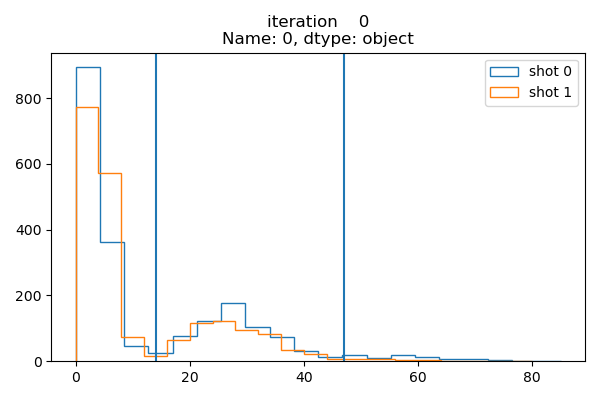

shot 0 Zero atom loading : 0.6516741629185407 +/- 0.01065085695024549
shot 1 Zero atom loading : 0.7151424287856072 +/- 0.010089894186054285
shot 0 Single atom loading : 0.3113443278360819 +/- 0.01035137397684896
shot 1 Single atom loading : 0.27436281859070466 +/- 0.009974677142183048
shot 0 Multi atom loading : 0.03698150924537731 +/- 0.0042187722846653815
shot 1 Multi atom loading : 0.010494752623688156 +/- 0.0022780938391027696
shot 0 Multi_to_Single atom loading : 0.11878009630818621 +/- 0.011178058096040056
shot 1 Multi_to_Single atom loading : 0.03825136612021858 +/- 0.010231514825799108


In [5]:
shots = 2

hists = True  # Display histograms of loading dataq
fit_cuts = True # Use cuts derived from fits? If not uses cut specified bellow
# Make sure fits have been made to use fit cuts
if fit_cuts:
    try:
        print(cuts)
    except NameError:
        fit_cuts = False
        
# Set count data variable, so this works regadless of device
cut = 14  # 0 atom - 1 atom cut
multi_cut = 47  # 1 atom - multi atom cut

if fit_cuts:
    exp_cuts = expand_iter_array(iterations,cuts,measurements,shots_per_measurement)
    exp_cut_errs = expand_iter_array(iterations,cut_errs,measurements,shots_per_measurement).mean(1)
    exp_multi_cuts = expand_iter_array(iterations,multi_cuts,measurements,shots_per_measurement)
    exp_overlaps = expand_iter_array(iterations,overlaps,measurements,shots_per_measurement).mean(1)
    
    zero_loading = (count_data < exp_cuts).sum(1)/measurements
    zero_loading_error_bar = sqrt(shot_error(zero_loading, measurements)**2+exp_overlaps**2)
    multi_loading = (count_data > exp_multi_cuts).sum(1)/measurements
    multi_loading_error_bar = shot_error(multi_loading, measurements)
    single_loading = 1-(zero_loading+multi_loading)
    single_loading_error_bar = sqrt(shot_error(single_loading, measurements)**2+exp_overlaps**2)
    multi_to_single_loading = multi_loading/single_loading
    multi_to_single_loading_error_bar = sqrt(multi_loading_error_bar**2 + single_loading_error_bar**2)
else:
    zero_loading = (count_data < cut).sum(1)/measurements
    zero_loading_error_bar = shot_error(zero_loading, measurements)
    multi_loading = (count_data > multi_cut).sum(1)/measurements
    multi_loading_error_bar = shot_error(multi_loading, measurements)
    single_loading = 1-(zero_loading+multi_loading)
    single_loading_error_bar = shot_error(single_loading, measurements)
    multi_to_single_loading = multi_loading/single_loading
    multi_to_single_loading_error_bar = sqrt(multi_loading_error_bar**2 + single_loading_error_bar**2)
    
loadings = {
    0: "Zero",
    1: "Single",
    2: "Multi",
    3: "Multi_to_Single"
}

if hists and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} histograms. Are you sure you want to do that? (y/N) : ").upper()[0]
    hists = ans=="Y"
    
if hists:
    fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(iteration)
        for shot in range(shots_per_measurement):
            axarr[iteration].hist(count_data[iteration,:,shot],histtype='step', label = f"shot {shot}",bins=20)
        axarr[iteration].legend()
        if fit_cuts:
            cut = cuts[iteration]
            multi_cut = multi_cuts[iteration]
            axarr[iteration].axvline(cut+cut_errs[iteration])
            axarr[iteration].axvline(cut-cut_errs[iteration])
        axarr[iteration].axvline(cut)
        axarr[iteration].axvline(multi_cut)
        axarr[iteration].set_title(str(row))
        fig.tight_layout()
    fig.show()
else:
    print("You have chosen not to plot the histograms.")
for num,name in loadings.items():
    rate = eval(f"{name.lower()}_loading")
    rate_error_bar = eval(f"{name.lower()}_loading_error_bar")
    default_plotting(iterations,rate,rate_error_bar,shots=shots,description = f"{name} atom loading")

# Retention

In [6]:
shots = 2

fit_cuts = True
# Use cuts derived from fitting in "Cuts" cell? If False hardcoded cut bellow will be used
if fit_cuts:
    try:
        print(f"printing cuts array {cuts}")
    except NameError:
        fit_cuts = False

# Set count data variable, so this works regadless of device
cut = 14  # 0 atom - 1 atom cut
multi_cut = 47  # 1 atom - multi atom cut

if fit_cuts:
    exp_cuts = expand_iter_array(iterations,cuts,measurements,shots_per_measurement)
    exp_cut_errs = expand_iter_array(iterations,cut_errs,measurements,shots_per_measurement).mean(1)
    exp_multi_cuts = expand_iter_array(iterations,multi_cuts,measurements,shots_per_measurement)
    exp_overlaps = expand_iter_array(iterations,overlaps,measurements,shots_per_measurement).mean(1).mean(1)
    
    single_loading = (count_data < exp_multi_cuts)*(count_data > exp_cuts) # Measurements that were loaded
else:
    single_loading = (count_data < multi_cut)*(count_data > cut)  # Measurements that were loaded
    exp_overlaps = 0  # Hardcode classification error rate here

retained = single_loading[...,1]*single_loading[...,0]  # Measurements that were retained
loaded = single_loading[...,0].sum(1)  # Number of loaded measurements in each iteration
#print(retained)
#print(loaded)
loaded = [10**-6 if l==0 else l for l in loaded]
#print(loaded)

retention = retained.sum(1)/loaded
retention_error_bar = sqrt(shot_error(retention,loaded)**2+exp_overlaps**2)

default_plotting(iterations,retention,retention_error_bar,description = "Retention")

shot 0 Retention : 0.8016260162601626 +/- 0.01608017242530942


<ipython-input-25-c14238e5700a>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


<IPython.core.display.Javascript object>


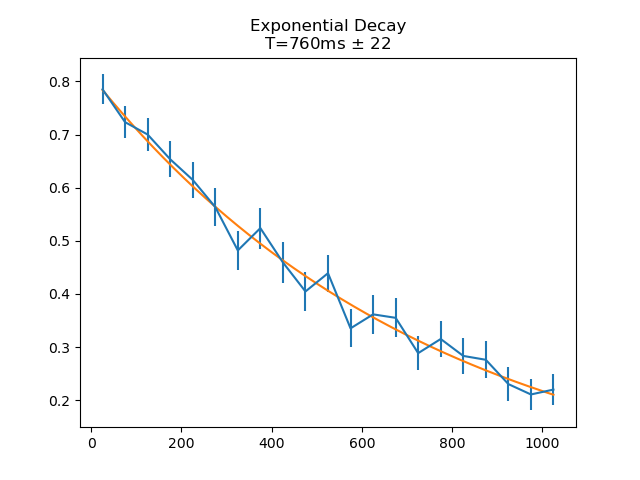

In [25]:
def exp_decay(x: float, a: float, Tau: float):
    return a*exp(-x/Tau)

guess = [
    0.8,
    800.0
]


xdat = iterations[iterations.ivars[0]]
popt, pcov = curve_fit(exp_decay, xdata=xdat, ydata=retention, sigma=retention_error_bar, p0=guess)
perr = sqrt(diag(pcov))

xlin = linspace(min(xdat),max(xdat),1000)
fig, ax = plt.subplots(1,1)
ax.errorbar(xdat,retention,yerr=retention_error_bar)
ax.plot(xlin,exp_decay(xlin,*popt))
ax.set_title(f"Exponential Decay\nT={popt[1]:.0f}ms $\pm$ {perr[1]:.0f}")
fig.show()

# Copy

In [11]:
# Copy to next results folder

import datetime
import shutil
import re
import os
import operator
from numpy import sort

volume = os.getcwd()[0]
analysis_fname = 'Analysis3.ipynb'
measurement_path = os.path.dirname(os.path.dirname(os.getcwd()))
dir_filter = lambda f : os.path.isdir(f)

# If the latest experiment folder already has an analysis file, should that be overwritten?
override = True

# find latest day folder created by cspy
daily_folders = list(filter(
    dir_filter,
    [os.path.join(measurement_path,f) for f in os.listdir(measurement_path)]
))  # make sure non-folder names are not listed
today_path = sort(daily_folders)[-1]
print(today_path)
#find all experiments taken on the last day
experiments_today = list(filter(
    dir_filter,
    [os.path.join(today_path,f) for f in os.listdir(today_path)]
))
#and the last experiment taken the last day
last_experiment = sort(experiments_today)[-1]
exp_path = os.path.join(today_path, last_experiment)

# Copy
if analysis_fname not in os.listdir(exp_path) or override:
    print("Copying {} from :\n\t{}\nto:\n\t{}".format(analysis_fname,os.getcwd(),exp_path))
    shutil.copy(os.path.join(os.getcwd(),analysis_fname),exp_path)
else:
    print("Folder {} already have analysis file. If you wish to overwrite that file set 'override' to True".format(exp_path))

E:\Data\Measurements\2021_01_09
Copying Analysis3.ipynb from :
	E:\Data\Measurements\2021_01_09\2021_01_09_18_04_34_BL
to:
	E:\Data\Measurements\2021_01_09\2021_01_09_18_34_52_BL_AllBeamRO


In [ ]:
# Copy to Git Repo

import datetime
import shutil
import re
import os
import operator
from numpy import sort

if (os.name == 'posix'):
    repo_path = r"/Volumes/C/Public/Users/Hybrid/Repos/Hybrid_H5/H5_python3"
else:
    repo_path = r"C:\Users\Hybrid\Repos\Hybrid_H5\H5_python3"

volume = os.getcwd()[0]
analysis_fname = 'Analysis3.ipynb'
measurement_path = os.path.dirname(os.path.dirname(os.getcwd()))
dir_filter = lambda f : os.path.isdir(f)

# If the latest experiment folder already has an analysis file, should that be overwritten?
override = True

# Copy
if analysis_fname not in os.listdir(repo_path) or override:
    print(f"Copying {analysis_fname} from :\n\t{os.getcwd()}\nto:\n\t{repo_path}")
    shutil.copy(os.path.join(os.getcwd(),analysis_fname),repo_path)
else:
    print(f"Folder {repo_path} already have analysis file. If you wish to overwrite that file set 'override' to True")

# Settings

In [7]:
for name,group in h5file['settings/experiment/independentVariables/'].items():
    print(f"{name} : \t\t {group['function'][()]}")

AerotechZPos : 		 b'4.45'
AnalogGain : 		 b'1'
AndorExpT : 		 b'50'
BAChop : 		 b'False'
BA_Power : 		 b'0'
Blow_Away_time : 		 b'2'
CONEXFocus : 		 b'3.35'
CONEXHoriz : 		 b'2.4071'
DoChop : 		 b'False'
DropTime : 		 b'50'
Drop_Time : 		 b'0'
GapTime : 		 b'13'
ImageDelay : 		 b'0'
LAC_D2_detuning : 		 b'-3'
LAC_D2_power : 		 b'-3.0'
LAC_Time : 		 b'10'
LAC_hyperfine_power : 		 b'2.6'
LAC_shim_X : 		 b'0.2'
LAC_shim_Y : 		 b'-.07'
LAC_shim_Z : 		 b'0.75'
MOT_Andor_Gain : 		 b'200'
MOT_Background : 		 b'True'
MOT_Coil_Current : 		 b'15.4972563782'
MOT_loading_time : 		 b'50'
MOT_shim_X : 		 b'-0.676713317696'
MOT_shim_Y : 		 b'0.327559520808'
MOT_shim_Z : 		 b'-0.559807023169'
MOT_shutter_enable : 		 b'True'
MuxJrFocus : 		 b'6.18'
MuxJrHoriz : 		 b'7.239'
MuxJrVert : 		 b'11.615*0+5.66'
OP_HF_amplitude : 		 b'2.6'
OP_Time : 		 b'10'
OP_chop : 		 b'False'
OP_depump : 		 b'True'
OP_detuning : 		 b'25*0+30'
OP_power : 		 b'0'
OP_shelve_time : 		 b'0'
OP_shim_X_offset : 		 b'2'
OP_shim_Y_

# TODO
- Make array of iteration-by-iteration classification errors from Cuts cells.
    - Specifically, adding classification errors due to function overlaps and cut_uncertainty, in quadrature
- Compartmentalize parts of Cuts cells for ease of use
- Move Utility and Calibration functions to files
- Make functions inside files for general discrimination
- Load info like Cut values, Camera calibrations etc into variables or class attributes to be used throughout notebook

# Appendix
Code that was written once, perhaps incidentally, and may be useful in the future

## Optimization, Counter Data
Code bellow picked out a subset of iterations from a long optimization run, and loaded counter data from that run. It then performed some hacky versions of the above analyses on them (Loading and Retention) 

In [ ]:
its = len(h5file['iterations'])
iterations = 1
measurements = int(h5file['/settings/experiment/measurementsPerIteration'][()])
shots = 2
drop_bins = h5file["/iterations/0/variables/RO1_drops"][()]
ro_bins = h5file["/iterations/0/variables/RO1_bins"][()]
tot_bins = drop_bins+ro_bins
                   
bin_data = zeros((iterations,measurements,shots,tot_bins))

for iteration in range(iterations):
    for measurement in range(measurements):
        it = its - 2 - iteration
        adr = f"/iterations/{it}/measurements/{measurement}/data/counter/data"
        raw_data = array(h5file[adr][()])[0]
        for shot in range(shots):
            bin_data[iteration,measurement,shot,:] = raw_data[shot*tot_bins:(shot+1)*tot_bins]
            
count_data = bin_data[...,drop_bins:].sum(3)

In [ ]:
n_bins = 30
fig,axarr = plt_subplots(iterations,1,figsize=(6,4*iterations))
for iteration in range(iterations):
    iteration = int(iteration)
    # bin shot 0 and shot 1 the same way
    bns = linspace(count_data[iteration,:,:].min(), count_data[iteration,:,:].max(), n_bins)
    # bin shot 0 and shot 1 differently
    # bns = n_bins
    for shot in range(shots):
        axarr[iteration].hist(count_data[iteration,:,shot],histtype='step', label = f"shot {shot}",bins=bns)
    axarr[iteration].legend()
    axarr[iteration].set_title(str(its-1-iteration))
    fig.tight_layout()
fig.show()

In [ ]:
shots = 2

# Set count data variable, so this works regadless of device
cut = 70  # 0 atom - 1 atom cut
multi_cut = 195  # 1 atom - multi atom cut


single_loading = (count_data < multi_cut)*(count_data > cut)  # Measurements that were loaded
exp_overlaps = 0  # Hardcode classification error rate here

retained = single_loading[...,1]*single_loading[...,0]  # Measurements that were retained
loaded = single_loading[...,0].sum(1)  # Number of loaded measurements in each iteration
print(retained)
print(loaded)
loaded = [10**-6 if l==0 else l for l in loaded]
print(loaded)

retention = retained.sum(1)/loaded
retention_error_bar = sqrt(shot_error(retention,loaded)**2+exp_overlaps**2)

fig,ax = plt.subplots(1,1)
ax.errorbar(list(range(its-1,its-iterations-1,-1)),retention,retention_error_bar)
fig.show()


In [ ]:
# find optimized variables
opt_vars = []
for variable in h5file['settings/experiment/independentVariables'].items():
    optimizing = variable[1]['optimize'][()]
    # print(f"{variable[0]} : {variable[1]['optimize'][()]}")
    if optimizing:
        opt_vars.append(variable[0])
print(opt_vars)


its_df = pd.DataFrame(columns=['iteration'] + opt_vars)
# Load those values for our iterations into a dataframe
for iteration in range(iterations):
    it = its - 1 - iteration
    opt_vals = {'iteration': it}
    for var in opt_vars:
        adr = f"/iterations/{it}/variables/{var}"
        opt_vals.update({var:h5file[adr][()]})
    its_df = its_df.append(pd.DataFrame(opt_vals,index=[it]))
    

In [ ]:
its_df

In [ ]:
for var in its_df:
    print(f"{var}: {its_df[var].mean():.3f} +\- {its_df[var].std():.3f}")

In [ ]:
import numpy as np
def test_load_data(
        results_file: h5py.File,
        drop_bins: int,
        ro_bins: int,
        shots: int = None
) -> Tuple[ndarray, ndarray]:
    """
    Load data from a counter instrument into a numpy array

    results are indexed as follows
    > results = array[iteration, measurement, shot]
    Args:
        results_file: h5file object corresponding to the results.hdf5 file being analyzed
        drop_bins: number of bins to drop at the start of each shot
        ro_bins: number of readout bins expected in each shot
        shots: number of shots taken in the experiment. Default is 2

    Returns:
        (binned_counter_data, shot_counter_data)
            binned_counter_data : 4D numpy array holding the counter data taken by the given counter
                during the experiment. Each entry corresponds to the number of counts detected
                during a binning period
                indexed [iteration, measurement, shot, ro_bin]
            shot_counter_data : a 3D numpy array holding the counter data taken by the given counter
                during the experiment. Each entry corresponds to the number of counts detected
                during a shot. counts detected by the first drop_bins bins in a shot are discarded
                from this array
                shot_counter_data = binned_counter_data[..., drop_bins:].sum(3)
                indexed [iteration, measurement, shot]
    """
    num_its = len(results_file['iterations'])
    measurements = results_file['settings/experiment/measurementsPerIteration'][()]+1
    if shots is None:
        shots_per_measurement = int(
            results_file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])
    else:
        shots_per_measurement = shots

    binned_counter_data = np.zeros(
        (num_its, measurements, shots_per_measurement, drop_bins + ro_bins),
        dtype=int
    )

    for iteration, i_group in results_file['iterations'].items():
        # print(f"iteration : {iteration} : {type(iteration)}")
        for measurement, m_group in i_group['measurements'].items():
            # load data, a 1D array of counter data from the measurement, each entry corresponds to
            # the measured counts in a given binning period
            raw_data = np.array(m_group['data/counter/data'][()])[0]
            for shot in range(shots_per_measurement):
                tot_bins = drop_bins + ro_bins
                iteration = int(iteration)
                measurement = int(measurement)
                inds = {
                    "iteration": iteration,
                    "measurement": measurement,
                    "shot": shot,
                    "tot_bins": tot_bins,
                    "raw_data.shape": raw_data.shape
                }
                ind_msg = ",".join([f"{var} : {val}" for var, val in inds.items()])
                print(ind_msg)
                try:
                    binned_counter_data[iteration, measurement, shot, :] = raw_data[shot*tot_bins: (shot + 1) * tot_bins]
                except (IndexError, ValueError) as ie:
                    inds = {
                        "iteration": iteration,
                        "measurement": measurement,
                        "shot": shot,
                        "tot_bins": tot_bins,
                        "raw_data.shape": raw_data.shape}
                    print(iteration)
                    ind_msg = ",".join([f"{var} : {val}" for var, val in inds.items()])
                    print(f"Warning. Error for {ind_msg}\n {ie}")
                    continue

    shot_counter_data = binned_counter_data[..., drop_bins:].sum(3)

    return binned_counter_data, shot_counter_data

In [ ]:
drop_bins = h5file["/iterations/0/variables/RO1_drops"][()]
ro_bins = h5file["/iterations/0/variables/RO1_bins"][()]
shots_per_measurement = int(h5file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])
counter_bin, counter_shot = test_load_data(h5file, drop_bins, ro_bins)
count_data = counter_shot

In [ ]:
where(counter_bin == 0)

# Copy

In [11]:
# Copy to next results folder

import datetime
import shutil
import re
import os
import operator
from numpy import sort

volume = os.getcwd()[0]
analysis_fname = 'Analysis3.ipynb'
measurement_path = os.path.dirname(os.path.dirname(os.getcwd()))
dir_filter = lambda f : os.path.isdir(f)

# If the latest experiment folder already has an analysis file, should that be overwritten?
override = True

# find latest day folder created by cspy
daily_folders = list(filter(
    dir_filter,
    [os.path.join(measurement_path,f) for f in os.listdir(measurement_path)]
))  # make sure non-folder names are not listed
today_path = sort(daily_folders)[-1]
print(today_path)
#find all experiments taken on the last day
experiments_today = list(filter(
    dir_filter,
    [os.path.join(today_path,f) for f in os.listdir(today_path)]
))
#and the last experiment taken the last day
last_experiment = sort(experiments_today)[-1]
exp_path = os.path.join(today_path, last_experiment)

# Copy
if analysis_fname not in os.listdir(exp_path) or override:
    print("Copying {} from :\n\t{}\nto:\n\t{}".format(analysis_fname,os.getcwd(),exp_path))
    shutil.copy(os.path.join(os.getcwd(),analysis_fname),exp_path)
else:
    print("Folder {} already have analysis file. If you wish to overwrite that file set 'override' to True".format(exp_path))

E:\Data\Measurements\2021_01_09
Copying Analysis3.ipynb from :
	E:\Data\Measurements\2021_01_09\2021_01_09_18_04_34_BL
to:
	E:\Data\Measurements\2021_01_09\2021_01_09_18_34_52_BL_AllBeamRO


In [ ]:
# Copy to Git Repo

import datetime
import shutil
import re
import os
import operator
from numpy import sort

if (os.name == 'posix'):
    repo_path = r"/Volumes/C/Public/Users/Hybrid/Repos/Hybrid_H5/H5_python3"
else:
    repo_path = r"C:\Users\Hybrid\Repos\Hybrid_H5\H5_python3"

volume = os.getcwd()[0]
analysis_fname = 'Analysis3.ipynb'
measurement_path = os.path.dirname(os.path.dirname(os.getcwd()))
dir_filter = lambda f : os.path.isdir(f)

# If the latest experiment folder already has an analysis file, should that be overwritten?
override = True

# Copy
if analysis_fname not in os.listdir(repo_path) or override:
    print(f"Copying {analysis_fname} from :\n\t{os.getcwd()}\nto:\n\t{repo_path}")
    shutil.copy(os.path.join(os.getcwd(),analysis_fname),repo_path)
else:
    print(f"Folder {repo_path} already have analysis file. If you wish to overwrite that file set 'override' to True")